# **hsv_filter**

In [ ]:
import cv2
import numpy as np
from torchvision.datasets import ImageFolder

def auto_hsv_ranges(image_paths, lower_percentile=5, upper_percentile=95):
    all_h, all_s, all_v = [], [], []
    for path in image_paths:
        # 加載圖像並轉換為 HSV
        image = cv2.imread(path)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_image)
        all_h.extend(h.ravel())
        all_s.extend(s.ravel())
        all_v.extend(v.ravel())

    # 計算分位數範圍
    lower_hsv = (
        np.percentile(all_h, lower_percentile),
        np.percentile(all_s, lower_percentile),
        np.percentile(all_v, lower_percentile)
    )
    upper_hsv = (
        np.percentile(all_h, upper_percentile),
        np.percentile(all_s, upper_percentile),
        np.percentile(all_v, upper_percentile)
    )
    return lower_hsv, upper_hsv

def hsv_filter(image, lower_hsv, upper_hsv):
    # 將 PIL.Image 轉為 NumPy 陣列
    image_np = np.array(image)
    # 轉換為 HSV
    hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    # 應用 HSV 過濾
    mask = cv2.inRange(hsv_image, np.array(lower_hsv), np.array(upper_hsv))
    # 過濾圖像
    filtered_image = cv2.bitwise_and(image_np, image_np, mask=mask)
    # 返回 PIL.Image 格式
    return Image.fromarray(filtered_image)


class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None, hsv_filter_params=None):
        super().__init__(root, transform=transform)
        self.hsv_filter_params = hsv_filter_params

    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)

        # 應用 HSV 過濾（如果有指定範圍）
        if self.hsv_filter_params:
            lower_hsv, upper_hsv = self.hsv_filter_params
            image = hsv_filter(image, lower_hsv, upper_hsv)

        # 應用其他數據增強
        if self.transform is not None:
            image = self.transform(image)

        return image, target

# Data Setup

In [4]:
# 計算 HSV 範圍
# train_image_paths = [os.path.join(root, file) for root, _, files in os.walk('/content/drive/My Drive/2024_kaggle/train_data/') for file in files]
# lower_hsv, upper_hsv = auto_hsv_ranges(train_image_paths)
# print(f"Calculated HSV Ranges: Lower: {lower_hsv}, Upper: {upper_hsv}")
# 以下為上面三行得出的結果
lower_hsv = (5.0, 5.0, 8.0)
upper_hsv = (126.0, 235.0, 251.0)

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# 加載數據集，應用 HSV Filter
trainset = CustomImageFolder(
    root='/content/drive/My Drive/2024_kaggle/train_data/',
    transform=transform_train,
    hsv_filter_params=(lower_hsv, upper_hsv)
)

# 拆分訓練集和驗證集
train, valid = torch.utils.data.random_split(trainset, [len(trainset) - 100, 100])

# 加載數據
batch_size = 64
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True, num_workers=2)

Calculated HSV Ranges: Lower: (5.0, 5.0, 8.0), Upper: (126.0, 235.0, 251.0)


# 印出部分圖片與label

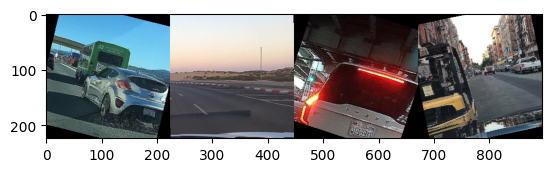

Class labels:  editada editada editada editada


In [ ]:
import numpy as np

classes = ('real', 'editada')

def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# print images and rotated images
imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **ConvNext**

In [8]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn, optim
#from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

random_seed = 999
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

class ConvNextModel(nn.Module):
    def __init__(self):
        super(ConvNextModel, self).__init__()
        #self.model = models.convnext_small(pretrained=True)
        self.model = models.convnext_small(weights = 'DEFAULT')
        self.model.classifier[2] = nn.Linear(self.model.classifier[2].in_features, 2)  # 將輸出類別數設定為 2
    def forward(self, x):
        return self.model(x)

convnext_model = ConvNextModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(convnext_model.parameters(), lr = 1e-4, weight_decay = 1e-3)

#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_val_loss = float('inf')  # 預設值Infinity
for epoch in range(num_epochs):
    convnext_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False): #加進度條
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = convnext_model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    scheduler.step()  # lr更新

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)




    # val
    convnext_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = convnext_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss = val_loss / len(val_loader)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")

    #儲存最佳model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(convnext_model.state_dict(), "/content/drive/My Drive/2024_kaggle/best_model.pth")
        print(f"Best model saved! (Epoch {epoch+1})")


epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))


# loss圖
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# acc圖
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 加載最佳模型
convnext_model.load_state_dict(torch.load("/content/drive/My Drive/2024_kaggle/best_model.pth"))
convnext_model.eval()

# test
test_dir = "/content/drive/My Drive/2024_kaggle/test_data"
test_images = sorted(os.listdir(test_dir))
test_data = []

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    img = Image.open(img_path)
    img = transform_test(img).unsqueeze(0).to(device)

    convnext_model.eval()
    with torch.no_grad():
        output = convnext_model(img)
        _, predicted = torch.max(output.data, 1)
        test_data.append((img_name, predicted.item()))

# 生成csv
submission = pd.DataFrame(test_data, columns=["image", "label"])
submission.to_csv("/content/drive/My Drive/2024_kaggle/submission.csv", index=False)

print("Submission file created at '/content/drive/My Drive/2024_kaggle/submission.csv'")

Epoch 1/15, Loss: 0.7185
Validation Accuracy: 63.00%
Validation Loss: 0.6713
Best model saved! (Epoch 1)


KeyboardInterrupt: 